
Generating Plot 1...


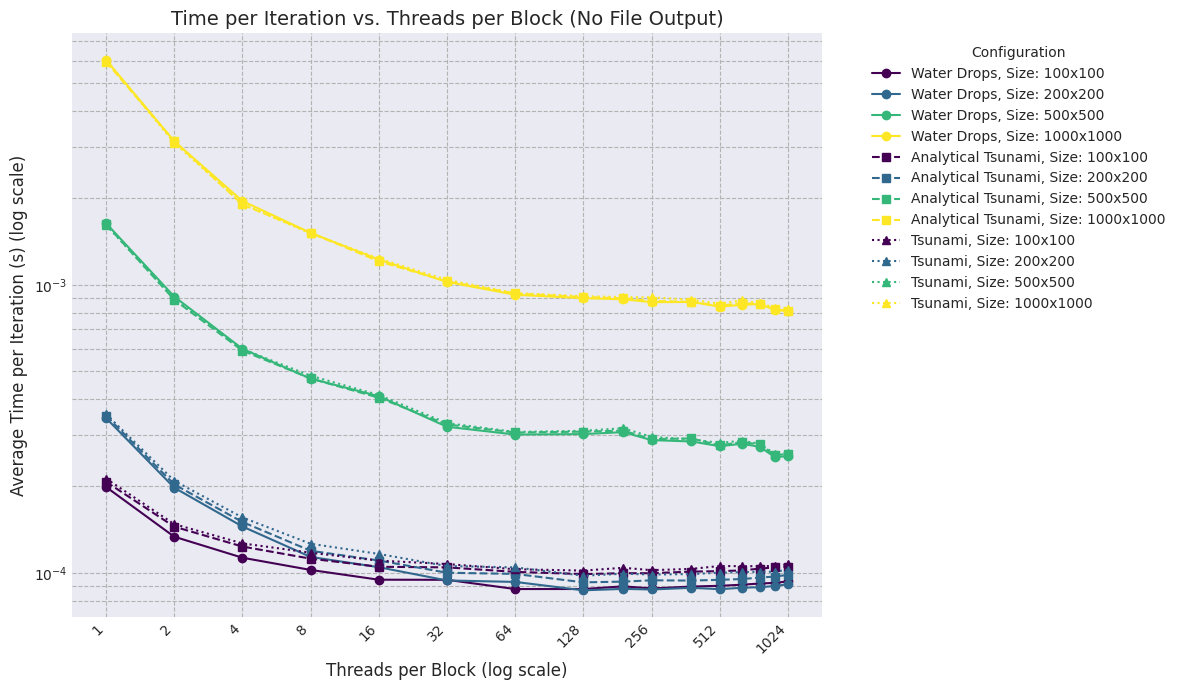

Plot 1 saved as time_per_iteration_no_file_output.png

Generating Plot 2...


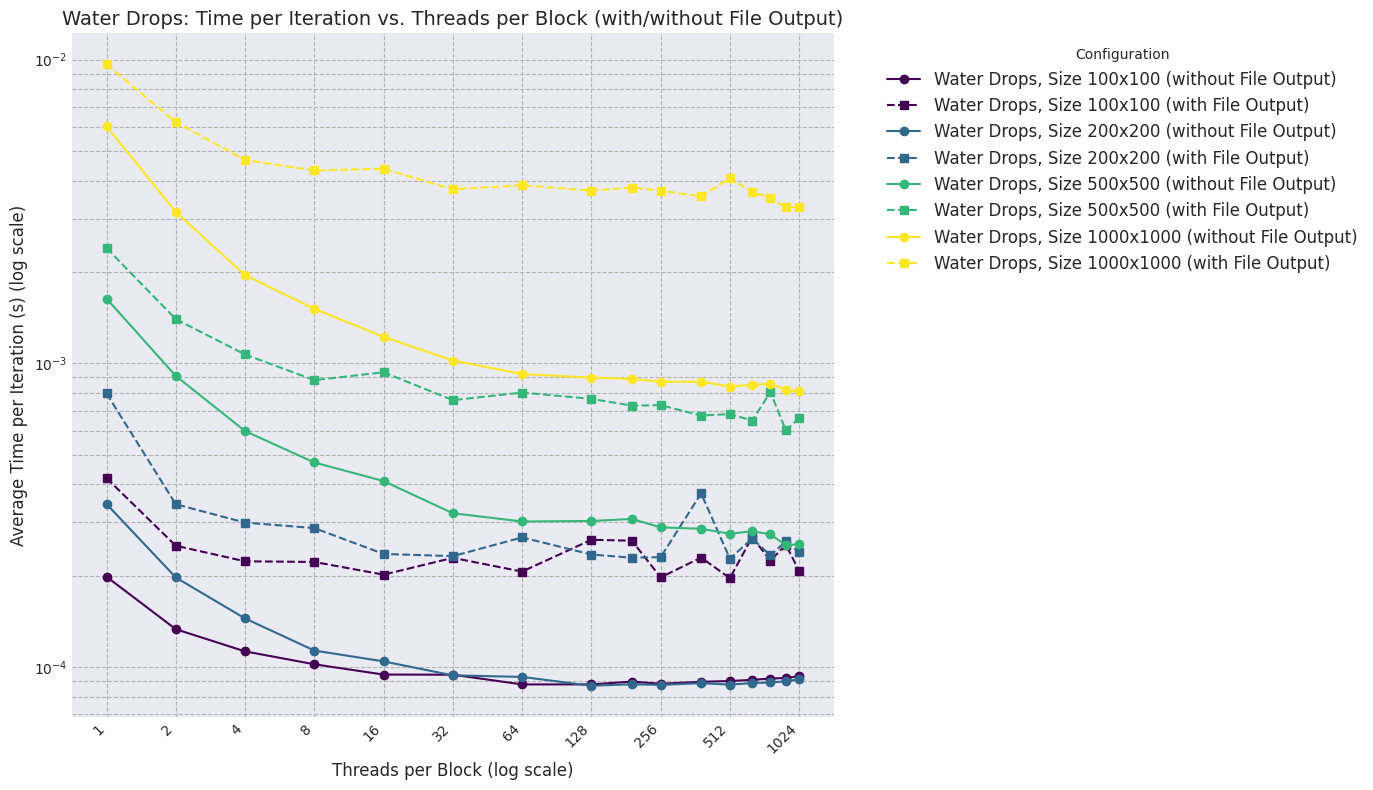

Plot 2 saved as case1_time_per_iteration_file_output_comparison.png


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Define sizes, cases, and threads_per_block globally for consistency
sizes = [100, 200, 500, 1000]
cases = [1, 2, 3]
threads_per_block = [1, 2, 4, 8, 16, 32, 64, 128, 192, 256, 384, 512, 640, 768, 896, 1024]

# Create a consistent color map for sizes across all plots
unique_sizes = sorted(sizes)
colors_for_sizes = plt.cm.viridis(np.linspace(0, 1, len(unique_sizes)))
size_color_map = dict(zip(unique_sizes, colors_for_sizes))

# Define descriptive names for cases
case_names = {
    1: 'Water Drops',
    2: 'Analytical Tsunami',
    3: 'Tsunami'
}

# Define specific styles for each case for Plot 1
case_styles_plot1 = {
    'Water Drops': {'marker': 'o', 'linestyle': '-'},
    'Analytical Tsunami': {'marker': 's', 'linestyle': '--'},
    'Tsunami': {'marker': '^', 'linestyle': ':'}
}

# Filter x-axis ticks to only powers of 2
power_of_2_ticks = [tpb for tpb in threads_per_block if (tpb & (tpb - 1) == 0) and tpb != 0]


# --- 2. Data Loading and Preprocessing ---

def load_and_process_data(file_paths):
    """Loads CSV files, calculates time per iteration, and averages repetitions.
    It also extracts the case_id from the filename for plotting purposes.
    """
    all_data = []
    for f_path in file_paths:
        if os.path.exists(f_path):
            df = pd.read_csv(f_path)
            # Extract case_id from filename: filename like 'caseX_nxY.csv' or 'caseX_nxY_nout10.csv'
            try:
                case_id_str = f_path.split('case')[1].split('_')[0]
                df['case_id'] = int(case_id_str)
            except (IndexError, ValueError):
                df['case_id'] = np.nan # Assign NaN if case_id cannot be extracted
                print(f"Could not extract case_id from filename: {f_path}")

            # Calculate time per iteration, handle cases with 0 iterations to avoid division by zero
            df['time_per_iteration'] = df.apply(
                lambda row: row['time(s)'] / row['iterations'] if row['iterations'] > 0 else np.nan,
                axis=1
            )
            # Add a column to indicate if it's a file output run based on filename suffix
            df['file_output'] = '_nout10' in f_path
            all_data.append(df)
        else:
            print(f"Warning: File not found - {f_path}")

    if not all_data:
        return pd.DataFrame() # Return empty DataFrame if no data loaded

    combined_df = pd.concat(all_data)
    # Group by case_id, nx, threadsPerBlock, and file_output, then average time_per_iteration
    # This correctly averages repetitions within each specific configuration.
    avg_df = combined_df.groupby(['case_id', 'nx', 'threadsPerBlock', 'file_output'], as_index=False)['time_per_iteration'].mean()
    return avg_df

# --- 3. Plotting ---

# Plot 1: Time per iteration vs threadsPerBlock for different sizes without file-writing
# Each case is plotted separately, and within each case, different sizes are shown with consistent colors.
# Different markers and line styles are used for different cases as per case_styles_plot1.
print("\nGenerating Plot 1...")
plot1_files = []
for case_id in cases:
    for size in sizes:
        plot1_files.append(f"case{case_id}_nx{size}.csv")

plot1_data = load_and_process_data(plot1_files)

if not plot1_data.empty:
    plt.figure(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-darkgrid')

    # Filter data to include only runs without file output
    plot1_data_filtered = plot1_data[plot1_data['file_output'] == False]

    # Plot each case separately
    for case_id_val in sorted(plot1_data_filtered['case_id'].unique()):
        case_name = case_names.get(case_id_val, f"Case {case_id_val}")
        style = case_styles_plot1.get(case_name, {'marker': 'x', 'linestyle': '-'}) # Default style

        case_subset = plot1_data_filtered[plot1_data_filtered['case_id'] == case_id_val]
        for size_val in sorted(case_subset['nx'].unique()):
            subset = case_subset[case_subset['nx'] == size_val]

            plt.plot(subset['threadsPerBlock'], subset['time_per_iteration'],
                     marker=style['marker'], linestyle=style['linestyle'],
                     label=f'{case_name}, Size: {size_val}x{size_val}',
                     color=size_color_map[size_val]) # Use consistent color map for sizes

    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.xlabel('Threads per Block (log scale)', fontsize=12)
    plt.ylabel('Average Time per Iteration (s) (log scale)', fontsize=12)
    plt.title('Time per Iteration vs. Threads per Block (No File Output)', fontsize=14)
    # Set x-axis ticks to show only powers of 2
    plt.xticks(power_of_2_ticks, labels=[str(t) for t in power_of_2_ticks], rotation=45, ha='right')
    plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig("swe_cuda_no_output.pdf")
    plt.show()
    print("Plot 1 saved as time_per_iteration_no_file_output.png")
else:
    print("No data to plot for Plot 1. Please ensure your CSV files are present.")


# Plot 2: Time per iteration vs threadsPerBlock with and without file output for case1
# Uses the same colors for sizes as Plot 1, but differentiates file output with line styles.
print("\nGenerating Plot 2...")
plot2_files = []
for size in sizes:
    plot2_files.append(f"case1_nx{size}.csv")
    plot2_files.append(f"case1_nx{size}_nout10.csv")

plot2_data = load_and_process_data(plot2_files)

if not plot2_data.empty:
    plt.figure(figsize=(14, 8))
    plt.style.use('seaborn-v0_8-darkgrid')

    line_styles = {False: '-', True: '--'} # Solid line for no output, dashed for output
    markers = {False: 'o', True: 's'} # Circle marker for no output, square for output

    # Iterate through unique sizes for Case 1
    for size_val in sorted(plot2_data['nx'].unique()):
        # Plot for 'without File Output'
        subset_no_output = plot2_data[(plot2_data['nx'] == size_val) & (plot2_data['file_output'] == False)]
        plt.plot(subset_no_output['threadsPerBlock'], subset_no_output['time_per_iteration'],
                 marker=markers[False], linestyle=line_styles[False],
                 label=f'{case_names.get(1, "Case 1")}, Size {size_val}x{size_val} (without File Output)',
                 color=size_color_map[size_val])

        # Plot for 'with File Output'
        subset_with_output = plot2_data[(plot2_data['nx'] == size_val) & (plot2_data['file_output'] == True)]
        plt.plot(subset_with_output['threadsPerBlock'], subset_with_output['time_per_iteration'],
                 marker=markers[True], linestyle=line_styles[True],
                 label=f'{case_names.get(1, "Case 1")}, Size {size_val}x{size_val} (with File Output)',
                 color=size_color_map[size_val])

    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.xlabel('Threads per Block (log scale)', fontsize=12)
    plt.ylabel('Average Time per Iteration (s) (log scale)', fontsize=12)
    plt.title(f'{case_names.get(1, "Case 1")}: Time per Iteration vs. Threads per Block (with/without File Output)', fontsize=14)
    # Set x-axis ticks to show only powers of 2
    plt.xticks(power_of_2_ticks, labels=[str(t) for t in power_of_2_ticks], rotation=45, ha='right')
    plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig("swe_cuda_case1_output.pdf")
    plt.show()
    print("Plot 2 saved as case1_time_per_iteration_file_output_comparison.png")
else:
    print("No data to plot for Plot 2. Please ensure your CSV files are present.")

# --- 4. Cleanup (optional) ---
# This section is commented out as it's for dummy file cleanup.
# If you wish to remove your actual CSVs after plotting, uncomment with caution.
# for case_id in cases:
#     for size in sizes:
#         os.remove(f"case{case_id}_nx{size}.csv")
#         if case_id == 1:
#             os.remove(f"case{case_id}_nx{size}_nout10.csv")
# print("\nCleaned up dummy CSV files.")
